<a href="https://colab.research.google.com/github/wodwiii/Stock-Price-Prediction-using-Monte-Carlo-Simulation/blob/main/Stock_Price_Prediction_w_Monte_Carlo_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
import math
from scipy.stats import mode
from scipy.stats import norm

In [ ]:
def upload_data_file():
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    return filename, uploaded[filename]

filename, file_content = upload_data_file()

Saving Price-History_20231204_2217 (1).xlsx to Price-History_20231204_2217 (1).xlsx


In [ ]:
df = pd.read_excel(BytesIO(file_content), sheet_name='Sheet 1', skiprows=26, nrows = 880)

In [ ]:
# Reverse the order of rows in the DataFrame to have the most recent observations first
# and reset the index while discarding the old index
df = df.iloc[::-1].reset_index(drop=True)

# Select only the first 10 columns of the DataFrame, retaining the relevant information
df = df.iloc[:, :10]
df.columns = ['Date', 'Close', 'Net', 'PercentChange', 'Open', 'Low', 'High', 'Volume', 'TurnoverPHP', 'Flow']

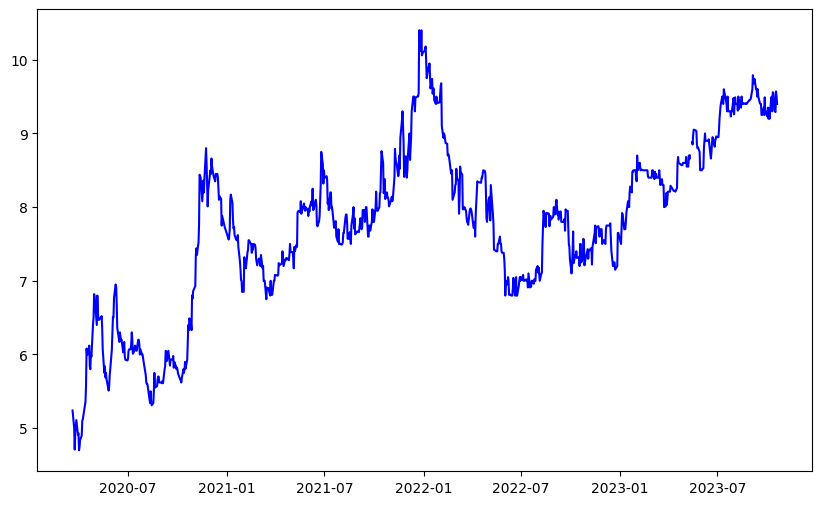

In [ ]:
# Plot the historical stock prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Historical Stock Prices', color='blue')

In [ ]:
df['Close'].iloc[-1]

9.4

In [ ]:
# Calculate the number of days that have elapsed in your chosen time window
time_elapsed = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days
print("Time elapsed :", str(time_elapsed))
# Calculate the total growth percentage
total_growth = (df['Close'].iloc[-1] / df['Close'].iloc[0])

# Annualize the growth percentage
number_of_years = time_elapsed / 365.0
cagr = total_growth ** (1/number_of_years) - 1

# Calculate the standard deviation of daily price changes
std_dev = df['Close'].pct_change().std()

# Annualize the standard deviation
number_of_trading_days = 252
std_dev = std_dev * math.sqrt(number_of_trading_days)

# Display the calculated mean returns (CAGR) and standard deviation of returns
print("CAGR (mean returns):", str(round(cagr, 4)))
print("Std Dev (standard deviation of return):", str(round(std_dev, 4)))

# Simulate the random walk process
number_of_trials = 50000
closing_prices = []
price_series_all = []
number_of_yrs = 1
prediction_days = 252 * number_of_yrs
for i in range(number_of_trials):
    # Calculate randomized return percentages following a normal distribution
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev/math.sqrt(number_of_trading_days), prediction_days) + 1
    price_series = [df['Close'].iloc[-1]]

    for j in daily_return_percentages:
        # Extrapolate price for the next trading day
        price_series.append(price_series[-1] * j)

    # Append closing prices for histogram
    closing_prices.append(price_series[-1])

    # Append the entire price series for all simulations
    price_series_all.append(price_series)


Time elapsed : 1309
CAGR (mean returns): 0.177
Std Dev (standard deviation of return): 0.3218


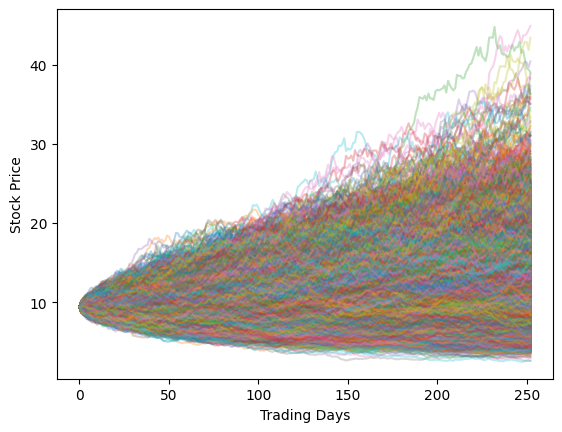

In [ ]:
# Plot individual simulated price series
for series in price_series_all:
    plt.plot(series, alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('Trading Days')
plt.ylabel('Stock Price')
plt.show()

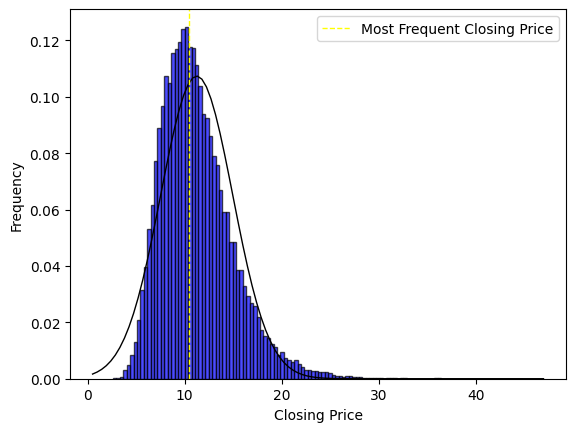

In [ ]:
rounded_closing_prices = [round(price, 4) for price in closing_prices]

# Plot histogram of rounded closing prices with curve lines
plt.hist(rounded_closing_prices, bins=120, color='blue', alpha=0.7, density=True, edgecolor='black')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')

# Plot a smooth curve line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(rounded_closing_prices), np.std(rounded_closing_prices))
plt.plot(x, p, 'k', linewidth=1)

# Find the bin with the highest frequency
hist, edges = np.histogram(rounded_closing_prices, bins=160)
most_frequent_bin_index = np.argmax(hist)
most_frequent_bin = (edges[most_frequent_bin_index], edges[most_frequent_bin_index + 1])

# Highlight the bin with the highest frequency
plt.axvline((most_frequent_bin[0] + most_frequent_bin[1]) / 2, color='yellow', linestyle='dashed', linewidth=1, label='Most Frequent Closing Price')

plt.legend()
plt.show()

In [ ]:
midpoint_most_frequent_bin = (most_frequent_bin[0] + most_frequent_bin[1]) / 2
print(f"Most probable closing price target: {round(midpoint_most_frequent_bin, 3)}")
print("\n")
# Calculate the mean of all ending prices
median_ending_price = np.median(closing_prices);
print(f"Median of closing price : {round(median_ending_price, 3)}")
print("\n")

mean_ending_price = np.mean(closing_prices)
print("Average of closing price:", str(round(mean_ending_price, 4)))


Most probable closing price target: 10.41


Median of closing price : 10.69


Average of closing price: 11.2414


In [ ]:
# Calculate the probability of breaking even
current_value = 9.4
probability_breaking_even = (np.array(closing_prices) >= current_value).mean()
print(f"Probability of breaking even: {probability_breaking_even*100:.2f}%")
print("\n")

# Calculate the probabilities of getting 11, 12, and 13 as the price level for the next specified days
price_levels = [10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15]
probabilities = [(np.array(closing_prices) >= level).mean() for level in price_levels]

for level, probability in zip(price_levels, probabilities):
    print(f"Probability of getting {level} as the price target: {probability*100:.2f}%")

# Calculate the maximum price loss at certain confidence levels (90%, 95%, and 99%)
confidence_levels = [90, 95, 99]
price_losses = [np.percentile(np.maximum(0, df['Close'].iloc[-1] - closing_prices), level) for level in confidence_levels]
current_value = df['Close'].iloc[-1]

print("\n")
for level, price_loss in zip(confidence_levels, price_losses):
    percent_loss = (price_loss / current_value) * 100
    print(f"Maximum price loss with {level}% confidence: {price_loss:.2f}(-{percent_loss:.2f}%)")

Probability of breaking even: 65.75%


Probability of getting 10.5 as the price target: 52.21%
Probability of getting 11 as the price target: 46.30%
Probability of getting 11.5 as the price target: 40.79%
Probability of getting 12 as the price target: 35.86%
Probability of getting 12.5 as the price target: 31.21%
Probability of getting 13 as the price target: 27.07%
Probability of getting 13.5 as the price target: 23.20%
Probability of getting 14 as the price target: 19.88%
Probability of getting 14.5 as the price target: 16.94%
Probability of getting 15 as the price target: 14.43%


Maximum price loss with 90% confidence: 2.34(-24.84%)
Maximum price loss with 95% confidence: 3.12(-33.17%)
Maximum price loss with 99% confidence: 4.37(-46.44%)


In [ ]:
# Calculate percentiles
percentiles = [50, 75, 99, 99.9, 99.99, 99.999, 99.9999]
percentile_values = np.percentile(rounded_closing_prices, percentiles)

for percentile, value in zip(percentiles, percentile_values):
    print(f"{percentile}th percentile: {value:.2f}")

50th percentile: 10.69
75th percentile: 13.25
99th percentile: 22.65
99.9th percentile: 29.08
99.99th percentile: 38.22
99.999th percentile: 44.12
99.9999th percentile: 44.80
